# Nonlinear Walk Gram Matrix Equivariant Features for Graph Discrimination

This notebook demonstrates how **nonlinear walk Gram matrices** can be used to distinguish non-isomorphic graph pairs. The method applies pointwise nonlinearities (tanh, softplus, ReLU, etc.) to the random walk propagation process, producing an equivariant Gram matrix whose spectral properties serve as graph fingerprints.

**What this demo does:**
1. Loads graph pairs from a benchmark dataset (cospectral, CSL, BREC categories)
2. Computes nonlinear walk Gram matrices with multiple nonlinearities and feature extraction strategies
3. Compares discrimination power against RWPE and nRWPE baselines
4. Verifies equivariance under permutation
5. Runs a trajectory length ablation study
6. Visualizes results with discrimination rates and distance distributions

In [1]:
import subprocess, sys

def install(packages):
    for pkg in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Core dependencies (always install)
install(["numpy", "matplotlib"])

# Colab-aware installs: skip pre-installed packages on Colab
_ON_COLAB = "google.colab" in sys.modules
if not _ON_COLAB:
    # These are pre-installed on Colab but not in a bare venv
    pass  # numpy and matplotlib already handled above


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import json
import math
import os
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Data Loading

Load graph pair data from GitHub (with local fallback). Each example contains two graphs (adjacency matrices) and metadata about the pair category.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/experiment_iter4_nonlinear_walk/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
examples = data["datasets"][0]["examples"]
print(f"Loaded {len(examples)} graph pairs")
# Show category breakdown
cats = {}
for e in examples:
    cat = e.get("metadata_category", "unknown")
    cats[cat] = cats.get(cat, 0) + 1
for cat, count in sorted(cats.items()):
    print(f"  {cat}: {count} pairs")

Loaded 27 graph pairs
  BREC_Basic: 5 pairs
  BREC_Extension: 5 pairs
  BREC_Regular: 5 pairs
  CSL: 3 pairs
  cospectral: 8 pairs
  strongly_regular: 1 pairs


## Configuration

All tunable parameters are defined here. Adjust these to control computation time and scope.

In [5]:
# ── Configuration ──────────────────────────────────────────────────────────
T_DEFAULT = 30             # Default trajectory length
RWPE_STEPS = 20            # Number of random walk steps for RWPE baseline
DISC_THRESHOLD = 1e-6      # L2 distance threshold for discrimination
NONLINEARITIES = ["tanh", "softplus", "relu", "mild", "linear"]
ABLATION_T_VALUES = [5, 10, 15, 20, 30, 50]  # Trajectory length ablation values
N_VERIFY = 20              # Number of graphs for equivariance verification
N_PERMS = 10               # Permutations per graph for equivariance check
MAX_EXAMPLES = 0           # 0 = use all loaded examples

## Core Functions: Nonlinearity and Graph Computations

Define the pointwise nonlinearities, normalized adjacency, and the nonlinear walk Gram matrix computation $G = \sum_{t=0}^{T} X_t^T X_t$ where $X_0 = I$ and $X_t = \sigma(\hat{A} X_{t-1})$.

In [6]:
# ── Nonlinearity functions ───────────────────────────────────────────────────
def apply_nonlinearity(X: np.ndarray, name: str) -> np.ndarray:
    """Apply pointwise nonlinearity to matrix X."""
    if name == "tanh":
        return np.tanh(X)
    elif name == "softplus":
        # numerically stable softplus
        return np.where(X > 20, X, np.log1p(np.exp(np.clip(X, -500, 20))))
    elif name == "relu":
        return np.maximum(X, 0.0)
    elif name == "mild":
        # x * tanh(x) -- mild nonlinearity
        return X * np.tanh(X)
    elif name == "linear":
        return X.copy()
    else:
        raise ValueError(f"Unknown nonlinearity: {name}")


# ── Core Graph Computations ──────────────────────────────────────────────────
def normalized_adjacency(A: np.ndarray) -> np.ndarray:
    """Compute symmetric normalized adjacency: D^{-1/2} A D^{-1/2}."""
    deg = A.sum(axis=1)
    deg = np.where(deg == 0, 1.0, deg)  # handle isolated nodes
    d_inv_sqrt = 1.0 / np.sqrt(deg)
    return A * np.outer(d_inv_sqrt, d_inv_sqrt)


def compute_gram_matrix(A_norm: np.ndarray, nonlinearity: str, T: int) -> np.ndarray:
    """Compute nonlinear walk Gram matrix G = sum_{t=0}^{T} X_t^T X_t.

    X_0 = I_n, X_t = sigma(A_norm @ X_{t-1}).
    G is n x n, positive semidefinite.
    """
    n = A_norm.shape[0]
    X = np.eye(n, dtype=np.float64)  # X_0 = I
    G = np.eye(n, dtype=np.float64)  # G starts with X_0^T @ X_0 = I
    for _ in range(T):
        X = apply_nonlinearity(A_norm @ X, nonlinearity)
        G += X.T @ X
    return G

## Feature Extraction Strategies

Four strategies to extract invariant fingerprints from the Gram matrix:
- **Eigenvalue**: Sorted eigenvalues of G
- **Node Statistics**: Per-row statistics (diagonal, off-diagonal mean/std/etc.), sorted lexicographically
- **Diagonal**: Sorted diagonal entries
- **Hybrid**: Concatenation of sorted diagonal + sorted row sums

In [7]:
def extract_eigenvalue_fingerprint(G: np.ndarray) -> np.ndarray:
    """Strategy A: Sorted eigenvalues of G."""
    eigs = np.linalg.eigvalsh(G)
    return np.sort(eigs)


def extract_node_statistics(G: np.ndarray) -> np.ndarray:
    """Strategy B: Per-row statistics of G, sorted lexicographically.

    Returns n x 19 matrix (sorted rows).
    """
    n = G.shape[0]
    diag = np.diag(G)
    stats_list = []
    for i in range(n):
        row = G[i]
        offdiag = np.concatenate([row[:i], row[i+1:]])
        d = diag[i]
        mean_off = np.mean(offdiag) if len(offdiag) > 0 else 0.0
        std_off = np.std(offdiag) if len(offdiag) > 0 else 0.0
        # Skewness and kurtosis
        if len(offdiag) > 2 and std_off > 1e-15:
            skew = float(np.mean(((offdiag - mean_off) / std_off) ** 3))
            kurt = float(np.mean(((offdiag - mean_off) / std_off) ** 4))
        else:
            skew = 0.0
            kurt = 0.0
        max_off = np.max(offdiag) if len(offdiag) > 0 else 0.0
        min_off = np.min(offdiag) if len(offdiag) > 0 else 0.0
        med_off = np.median(offdiag) if len(offdiag) > 0 else 0.0
        q25 = np.percentile(offdiag, 25) if len(offdiag) > 0 else 0.0
        q75 = np.percentile(offdiag, 75) if len(offdiag) > 0 else 0.0
        rowsum = np.sum(row)
        l2norm = np.linalg.norm(row)
        sqsum = np.sum(row ** 2)
        l1_off = np.sum(np.abs(offdiag)) if len(offdiag) > 0 else 0.0
        # Top 5 sorted off-diagonal (pad with 0 if < 5)
        sorted_off = np.sort(offdiag)[::-1]
        top5 = np.zeros(5)
        top5[:min(5, len(sorted_off))] = sorted_off[:min(5, len(sorted_off))]
        stats = np.array([d, mean_off, std_off, skew, kurt, max_off, min_off,
                          med_off, q25, q75, rowsum, l2norm, sqsum, l1_off] + list(top5))
        stats_list.append(stats)
    stats_arr = np.array(stats_list)
    idx = np.lexsort(stats_arr.T[::-1])
    return stats_arr[idx]


def extract_diagonal_fingerprint(G: np.ndarray) -> np.ndarray:
    """Strategy C: Sorted diagonal of G."""
    return np.sort(np.diag(G))


def extract_hybrid_fingerprint(G: np.ndarray) -> np.ndarray:
    """Strategy D: concat(sorted diagonal, sorted row sums)."""
    diag_sorted = np.sort(np.diag(G))
    rowsums_sorted = np.sort(G.sum(axis=1))
    return np.concatenate([diag_sorted, rowsums_sorted])

## Baselines: RWPE and nRWPE

- **RWPE**: Diagonal of random walk powers $\text{diag}(RW^k)$ for $k=1,\ldots,K$
- **nRWPE-diag**: Diagonal of nonlinear walk self-similarity $\text{diag}(X_t X_t^T)$

In [8]:
def compute_rwpe(A: np.ndarray, steps: int) -> np.ndarray:
    """RWPE baseline: diag(RW^k) for k=1..steps, rows sorted."""
    n = A.shape[0]
    deg = A.sum(axis=1)
    deg = np.where(deg == 0, 1.0, deg)
    D_inv = np.diag(1.0 / deg)
    RW = A @ D_inv
    RW_power = np.eye(n, dtype=np.float64)
    features = np.zeros((n, steps), dtype=np.float64)
    for k in range(steps):
        RW_power = RW_power @ RW
        features[:, k] = np.diag(RW_power)
    idx = np.lexsort(features.T[::-1])
    return features[idx]


def compute_nrwpe_diag(A_norm: np.ndarray, T: int) -> np.ndarray:
    """nRWPE baseline: diag(X_t @ X_t^T) for tanh walk, rows sorted."""
    n = A_norm.shape[0]
    X = np.eye(n, dtype=np.float64)
    features = np.zeros((n, T), dtype=np.float64)
    for t in range(T):
        X = np.tanh(A_norm @ X)
        features[:, t] = np.sum(X ** 2, axis=1)
    idx = np.lexsort(features.T[::-1])
    return features[idx]

## Discrimination Test and Pair Processing

Check if two fingerprints differ by more than a threshold, and process each graph pair through all methods.

In [9]:
def is_distinguished(fp_A: np.ndarray, fp_B: np.ndarray, threshold: float = DISC_THRESHOLD) -> tuple:
    """Check if two fingerprints are distinguishable."""
    if fp_A.shape != fp_B.shape:
        return True, float("inf")
    dist = float(np.linalg.norm(fp_A - fp_B))
    return dist > threshold, dist


def process_single_pair(pair_data: dict, T: int = None) -> dict:
    """Process a single graph pair through all methods."""
    if T is None:
        T = T_DEFAULT
    inp = json.loads(pair_data["input"])
    A_a = np.array(inp["graph_A"]["adjacency_matrix"], dtype=np.float64)
    A_b = np.array(inp["graph_B"]["adjacency_matrix"], dtype=np.float64)

    A_norm_a = normalized_adjacency(A_a)
    A_norm_b = normalized_adjacency(A_b)

    results = {}

    # ── Baselines ──
    rwpe_a = compute_rwpe(A_a, RWPE_STEPS)
    rwpe_b = compute_rwpe(A_b, RWPE_STEPS)
    d, dist = is_distinguished(rwpe_a, rwpe_b)
    results["RWPE_diag"] = {"distinguished": d, "distance": dist}

    nrwpe_a = compute_nrwpe_diag(A_norm_a, T)
    nrwpe_b = compute_nrwpe_diag(A_norm_b, T)
    d, dist = is_distinguished(nrwpe_a, nrwpe_b)
    results["nRWPE_diag"] = {"distinguished": d, "distance": dist}

    # ── Our methods: G_NL with different nonlinearities and feature strategies ──
    for nl in NONLINEARITIES:
        G_a = compute_gram_matrix(A_norm_a, nl, T)
        G_b = compute_gram_matrix(A_norm_b, nl, T)

        # A) Eigenvalue fingerprint
        eig_a = extract_eigenvalue_fingerprint(G_a)
        eig_b = extract_eigenvalue_fingerprint(G_b)
        d, dist = is_distinguished(eig_a, eig_b)
        results[f"G_NL_eig_{nl}"] = {"distinguished": d, "distance": dist}

        # B) Node statistics fingerprint (only for tanh to save compute)
        if nl == "tanh":
            ns_a = extract_node_statistics(G_a)
            ns_b = extract_node_statistics(G_b)
            d, dist = is_distinguished(ns_a, ns_b)
            results[f"G_NL_nodestats_{nl}"] = {"distinguished": d, "distance": dist}

        # C) Diagonal fingerprint
        diag_a = extract_diagonal_fingerprint(G_a)
        diag_b = extract_diagonal_fingerprint(G_b)
        d, dist = is_distinguished(diag_a, diag_b)
        results[f"G_NL_diag_{nl}"] = {"distinguished": d, "distance": dist}

        # D) Hybrid fingerprint
        hyb_a = extract_hybrid_fingerprint(G_a)
        hyb_b = extract_hybrid_fingerprint(G_b)
        d, dist = is_distinguished(hyb_a, hyb_b)
        results[f"G_NL_hybrid_{nl}"] = {"distinguished": d, "distance": dist}

    return results

## Phase 1: Process All Graph Pairs

Run all discrimination methods on every graph pair in the dataset.

In [10]:
t_start = time.time()

if MAX_EXAMPLES > 0:
    examples = examples[:MAX_EXAMPLES]

n_examples = len(examples)
print(f"Processing {n_examples} pairs with nonlinearities: {NONLINEARITIES}")
print(f"T_DEFAULT={T_DEFAULT}, RWPE_STEPS={RWPE_STEPS}")

all_results = []
for i, ex in enumerate(examples):
    try:
        result = process_single_pair(ex, T_DEFAULT)
        all_results.append(result)
    except Exception as e:
        print(f"  Pair {i} failed: {e}")
        all_results.append({"error": str(e)})
    if (i + 1) % 10 == 0 or i == n_examples - 1:
        print(f"  [{i+1}/{n_examples}] elapsed={time.time()-t_start:.1f}s")

elapsed_phase1 = time.time() - t_start
print(f"\nPhase 1 complete in {elapsed_phase1:.1f}s")

Processing 27 pairs with nonlinearities: ['tanh', 'softplus', 'relu', 'mild', 'linear']
T_DEFAULT=30, RWPE_STEPS=20


  [10/27] elapsed=0.6s


  [20/27] elapsed=1.9s


  [27/27] elapsed=2.2s

Phase 1 complete in 2.2s


## Phase 2: Equivariance Verification

Verify that the Gram matrix transforms equivariantly under node permutation: $G(PAP^T) = P G(A) P^T$.

In [11]:
def verify_equivariance(A: np.ndarray, nonlinearity: str = "tanh",
                        T: int = None, n_perms: int = None, tol: float = 1e-8) -> dict:
    """Verify that G transforms equivariantly under permutation."""
    if T is None:
        T = T_DEFAULT
    if n_perms is None:
        n_perms = N_PERMS
    n = A.shape[0]
    A_norm = normalized_adjacency(A)
    G_orig = compute_gram_matrix(A_norm, nonlinearity, T)
    eigs_orig = np.sort(np.linalg.eigvalsh(G_orig))

    results = {"passed": True, "max_gram_error": 0.0, "max_eig_error": 0.0, "n_perms": n_perms}
    rng = np.random.RandomState(42)

    for _ in range(n_perms):
        perm = rng.permutation(n)
        P = np.eye(n)[perm]
        A_perm = P @ A @ P.T
        A_norm_perm = normalized_adjacency(A_perm)
        G_perm = compute_gram_matrix(A_norm_perm, nonlinearity, T)
        G_expected = P @ G_orig @ P.T
        gram_err = float(np.linalg.norm(G_perm - G_expected))
        eigs_perm = np.sort(np.linalg.eigvalsh(G_perm))
        eig_err = float(np.linalg.norm(eigs_perm - eigs_orig))

        results["max_gram_error"] = max(results["max_gram_error"], gram_err)
        results["max_eig_error"] = max(results["max_eig_error"], eig_err)
        if gram_err > tol or eig_err > tol:
            results["passed"] = False

    return results

print(f"Equivariance verification on {N_VERIFY} graphs with {N_PERMS} permutations each...")
equivariance_results = []
n_verify = min(N_VERIFY, n_examples)
for i in range(n_verify):
    try:
        inp = json.loads(examples[i]["input"])
        A = np.array(inp["graph_A"]["adjacency_matrix"], dtype=np.float64)
        ev = verify_equivariance(A, nonlinearity="tanh")
        equivariance_results.append({
            "pair_idx": i, "n_nodes": A.shape[0], **ev
        })
    except Exception as e:
        print(f"  Equivariance check failed for pair {i}: {e}")

all_passed = all(r["passed"] for r in equivariance_results)
print(f"Equivariance: {'ALL PASSED' if all_passed else 'SOME FAILED'}")
for r in equivariance_results:
    print(f"  pair={r['pair_idx']} n={r['n_nodes']} passed={r['passed']} "
          f"gram_err={r['max_gram_error']:.2e} eig_err={r['max_eig_error']:.2e}")

Equivariance verification on 20 graphs with 10 permutations each...


Equivariance: ALL PASSED
  pair=0 n=5 passed=True gram_err=0.00e+00 eig_err=2.89e-15
  pair=1 n=6 passed=True gram_err=0.00e+00 eig_err=0.00e+00
  pair=2 n=6 passed=True gram_err=2.43e-15 eig_err=9.04e-15
  pair=3 n=6 passed=True gram_err=3.20e-15 eig_err=9.42e-15
  pair=4 n=6 passed=True gram_err=6.28e-15 eig_err=7.74e-15
  pair=5 n=6 passed=True gram_err=4.35e-15 eig_err=2.14e-14
  pair=6 n=7 passed=True gram_err=0.00e+00 eig_err=0.00e+00
  pair=7 n=7 passed=True gram_err=2.43e-15 eig_err=9.87e-15
  pair=8 n=16 passed=True gram_err=6.06e-15 eig_err=2.19e-14
  pair=9 n=16 passed=True gram_err=6.06e-15 eig_err=2.19e-14
  pair=10 n=16 passed=True gram_err=6.06e-15 eig_err=2.19e-14
  pair=11 n=16 passed=True gram_err=1.20e-14 eig_err=1.16e-14
  pair=12 n=10 passed=True gram_err=4.80e-15 eig_err=2.19e-14
  pair=13 n=10 passed=True gram_err=2.32e-14 eig_err=2.54e-14
  pair=14 n=10 passed=True gram_err=6.19e-15 eig_err=1.48e-14
  pair=15 n=10 passed=True gram_err=4.96e-15 eig_err=3.27e-14
 

## Phase 3: Aggregate Results

Compute overall and per-category discrimination rates for each method.

In [12]:
# Collect all method names
method_names = set()
for r in all_results:
    if r and "error" not in r:
        method_names.update(r.keys())
method_names = sorted(method_names)

# Per-category aggregation
categories = {}
for i, ex in enumerate(examples):
    cat = ex.get("metadata_category", "unknown")
    if cat not in categories:
        categories[cat] = {"indices": [], "total": 0}
    categories[cat]["indices"].append(i)
    categories[cat]["total"] += 1

per_category = {}
for cat, info in sorted(categories.items()):
    per_category[cat] = {"total": info["total"]}
    for m in method_names:
        count = 0
        dists = []
        for idx in info["indices"]:
            r = all_results[idx]
            if r and "error" not in r and m in r:
                if r[m]["distinguished"]:
                    count += 1
                d = r[m]["distance"]
                if d != float("inf"):
                    dists.append(d)
        per_category[cat][m] = {
            "distinguished": count,
            "rate": count / info["total"] if info["total"] > 0 else 0.0,
            "median_distance": float(np.median(dists)) if dists else 0.0,
        }

# Overall aggregation
overall = {"total": n_examples}
for m in method_names:
    count = 0
    dists = []
    for r in all_results:
        if r and "error" not in r and m in r:
            if r[m]["distinguished"]:
                count += 1
            d = r[m]["distance"]
            if d != float("inf"):
                dists.append(d)
    overall[m] = {
        "distinguished": count,
        "rate": count / n_examples if n_examples > 0 else 0.0,
        "median_distance": float(np.median(dists)) if dists else 0.0,
    }

print("=== OVERALL RESULTS ===")
for m in method_names:
    o = overall[m]
    print(f"  {m:30s}: {o['distinguished']:>3d}/{n_examples} = {o['rate']:.4f}")

print("\n=== PER-CATEGORY RESULTS ===")
for cat in sorted(per_category.keys()):
    print(f"  --- {cat} ({per_category[cat]['total']} pairs) ---")
    for m in method_names:
        mc = per_category[cat][m]
        print(f"    {m:30s}: {mc['distinguished']:>3d}/{per_category[cat]['total']} = {mc['rate']:.4f}")

=== OVERALL RESULTS ===
  G_NL_diag_linear              :  26/27 = 0.9630
  G_NL_diag_mild                :  20/27 = 0.7407
  G_NL_diag_relu                :  26/27 = 0.9630
  G_NL_diag_softplus            :  26/27 = 0.9630
  G_NL_diag_tanh                :  26/27 = 0.9630
  G_NL_eig_linear               :  23/27 = 0.8519
  G_NL_eig_mild                 :  26/27 = 0.9630
  G_NL_eig_relu                 :  23/27 = 0.8519
  G_NL_eig_softplus             :  26/27 = 0.9630
  G_NL_eig_tanh                 :  26/27 = 0.9630
  G_NL_hybrid_linear            :  26/27 = 0.9630
  G_NL_hybrid_mild              :  23/27 = 0.8519
  G_NL_hybrid_relu              :  26/27 = 0.9630
  G_NL_hybrid_softplus          :  26/27 = 0.9630
  G_NL_hybrid_tanh              :  26/27 = 0.9630
  G_NL_nodestats_tanh           :  26/27 = 0.9630
  RWPE_diag                     :  26/27 = 0.9630
  nRWPE_diag                    :  26/27 = 0.9630

=== PER-CATEGORY RESULTS ===
  --- BREC_Basic (5 pairs) ---
    G_NL_diag_l

## Phase 4: Trajectory Length Ablation

Test how the discrimination power of the tanh eigenvalue method varies with trajectory length $T$.

In [13]:
print(f"Trajectory length ablation for G_NL_eig_tanh at T = {ABLATION_T_VALUES}")
ablation_results = {}

for T_val in ABLATION_T_VALUES:
    disc_count = 0
    for i, ex in enumerate(examples):
        try:
            inp = json.loads(ex["input"])
            A_a = np.array(inp["graph_A"]["adjacency_matrix"], dtype=np.float64)
            A_b = np.array(inp["graph_B"]["adjacency_matrix"], dtype=np.float64)
            A_norm_a = normalized_adjacency(A_a)
            A_norm_b = normalized_adjacency(A_b)
            G_a = compute_gram_matrix(A_norm_a, "tanh", T_val)
            G_b = compute_gram_matrix(A_norm_b, "tanh", T_val)
            eig_a = extract_eigenvalue_fingerprint(G_a)
            eig_b = extract_eigenvalue_fingerprint(G_b)
            d, dist = is_distinguished(eig_a, eig_b)
            if d:
                disc_count += 1
        except Exception:
            pass

    rate = disc_count / n_examples if n_examples > 0 else 0.0
    ablation_results[T_val] = {"distinguished": disc_count, "rate": rate}
    print(f"  T={T_val:>3d}: {disc_count}/{n_examples} = {rate:.4f}")

elapsed_total = time.time() - t_start
print(f"\nTotal runtime: {elapsed_total:.1f}s")

Trajectory length ablation for G_NL_eig_tanh at T = [5, 10, 15, 20, 30, 50]
  T=  5: 26/27 = 0.9630
  T= 10: 26/27 = 0.9630
  T= 15: 26/27 = 0.9630
  T= 20: 26/27 = 0.9630
  T= 30: 26/27 = 0.9630


  T= 50: 26/27 = 0.9630

Total runtime: 4.3s


## Visualization

Plot overall discrimination rates and trajectory length ablation results.

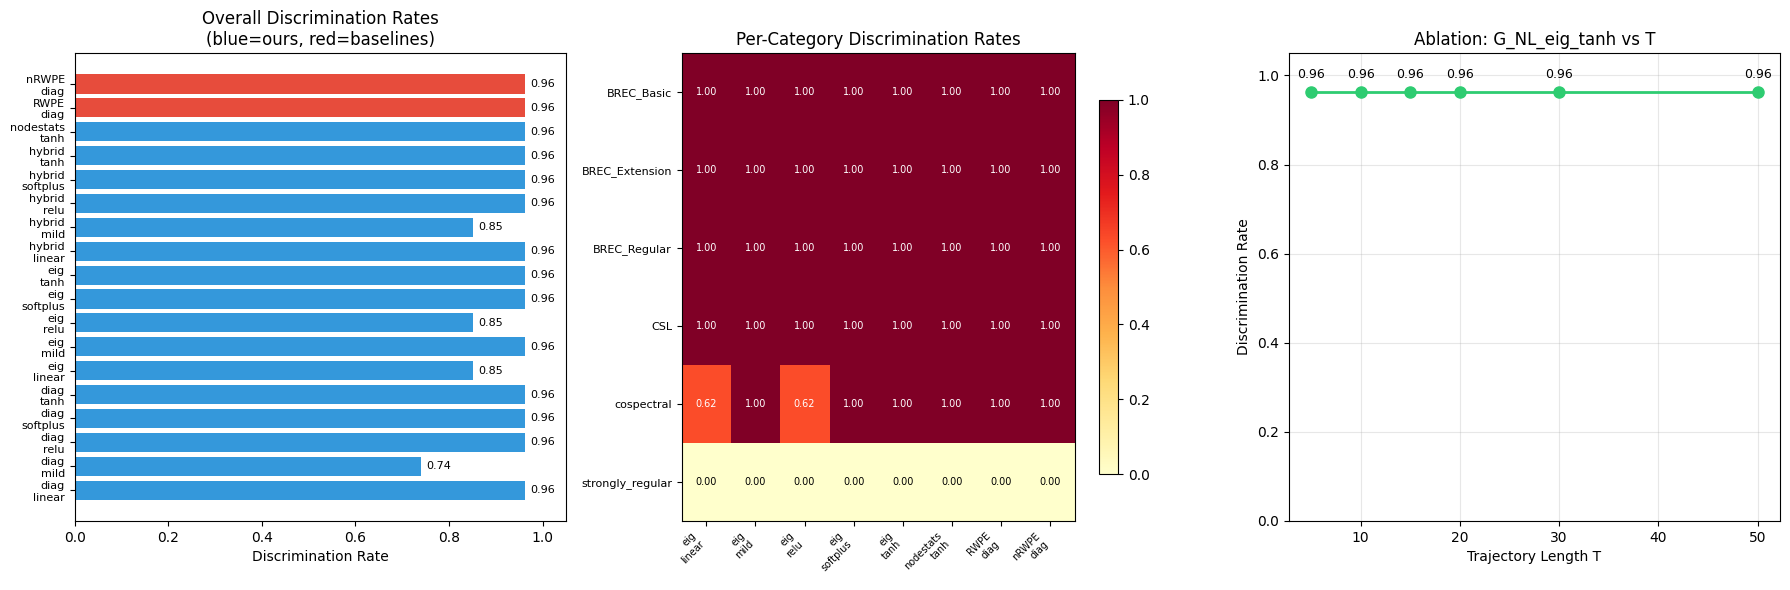

Visualization saved to results_visualization.png


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ── Plot 1: Overall Discrimination Rates ──
ax = axes[0]
methods = sorted(method_names)
rates = [overall[m]["rate"] for m in methods]
colors = ["#e74c3c" if "RWPE" in m or "nRWPE" in m else "#3498db" for m in methods]
short_names = [m.replace("G_NL_", "").replace("_", "\n") for m in methods]
bars = ax.barh(range(len(methods)), rates, color=colors)
ax.set_yticks(range(len(methods)))
ax.set_yticklabels(short_names, fontsize=8)
ax.set_xlabel("Discrimination Rate")
ax.set_title("Overall Discrimination Rates\n(blue=ours, red=baselines)")
ax.set_xlim(0, 1.05)
for i, (r, m) in enumerate(zip(rates, methods)):
    ax.text(r + 0.01, i, f"{r:.2f}", va="center", fontsize=8)

# ── Plot 2: Per-Category Heatmap ──
ax = axes[1]
cat_names = sorted(per_category.keys())
# Pick a subset of representative methods for the heatmap
repr_methods = [m for m in methods if "eig" in m or "RWPE" in m or "nRWPE" in m or "nodestats" in m]
if not repr_methods:
    repr_methods = methods[:6]
heatmap_data = np.array([
    [per_category[cat][m]["rate"] for m in repr_methods]
    for cat in cat_names
])
im = ax.imshow(heatmap_data, aspect="auto", cmap="YlOrRd", vmin=0, vmax=1)
ax.set_xticks(range(len(repr_methods)))
ax.set_xticklabels([m.replace("G_NL_", "").replace("_", "\n") for m in repr_methods],
                    fontsize=7, rotation=45, ha="right")
ax.set_yticks(range(len(cat_names)))
ax.set_yticklabels(cat_names, fontsize=8)
ax.set_title("Per-Category Discrimination Rates")
for i in range(len(cat_names)):
    for j in range(len(repr_methods)):
        ax.text(j, i, f"{heatmap_data[i, j]:.2f}", ha="center", va="center", fontsize=7,
                color="white" if heatmap_data[i, j] > 0.5 else "black")
plt.colorbar(im, ax=ax, shrink=0.8)

# ── Plot 3: Trajectory Length Ablation ──
ax = axes[2]
T_vals = sorted(ablation_results.keys())
abl_rates = [ablation_results[t]["rate"] for t in T_vals]
ax.plot(T_vals, abl_rates, "o-", color="#2ecc71", linewidth=2, markersize=8)
ax.set_xlabel("Trajectory Length T")
ax.set_ylabel("Discrimination Rate")
ax.set_title("Ablation: G_NL_eig_tanh vs T")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
for t, r in zip(T_vals, abl_rates):
    ax.annotate(f"{r:.2f}", (t, r), textcoords="offset points", xytext=(0, 10),
                ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("results_visualization.png", dpi=150, bbox_inches="tight")
plt.show()
print("Visualization saved to results_visualization.png")